# 9.2 Optimising with NumPy

*Estimated time for this notebook: 30 minutes*

If we have our values in a numpy `ndarray`, we apply operations to each element in the array in one go, without having to loop over it. 

## 9.2.1 Operations on arrays

First, we want a `ndarray` containing the complex values that we previously used as input to our function.

In [1]:
xmin = -1.5
ymin = -1.0
xmax = 0.5
ymax = 1.0
resolution = 300
xstep = (xmax - xmin) / resolution
ystep = (ymax - ymin) / resolution
xs = [(xmin + xstep * i) for i in range(resolution)]
ys = [(ymin + ystep * i) for i in range(resolution)]
# list with complex values
cs_listcomp = [[(x + y * 1j) for x in xs] for y in ys]

In [2]:
import numpy as np

In [3]:
cs = np.asarray(cs_listcomp)

In [4]:
cs.shape

(300, 300)

We now want to compare adding a constant to every element of the array by 
1) using a for loop
2) using numpy operators.

In [5]:
# we need to make copies of array to avoid overwriting it
cs_loop = cs.copy()
cs_numpy = cs.copy()

In [6]:
%%timeit
for i in range(cs_loop.shape[0]):
    for j in range(cs_loop.shape[1]):
        cs_loop[i][j] = cs_loop[i][j] + 10

56.9 ms ± 536 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


Sometimes, you can use operators such as `+` as if we were dealing with single values. This is because the Numpy ndarrays have overridden the `__add__` operation.

In [7]:
%%timeit
cs_numpy + 10

106 µs ± 3.53 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


But most Python functions do not know how to handle multi-dimensional arrays so we'll use Numpy implementations where they exist.

In [8]:
import math

math.sqrt(cs)

TypeError: only size-1 arrays can be converted to Python scalars

In [9]:
np.sqrt(cs)

array([[0.38908588-1.28506335j, 0.38980707-1.28268581j,
        0.39053184-1.28030535j, ..., 0.89141291-0.56090729j,
        0.89409221-0.55922644j, 0.8967725 -0.55755501j],
       [0.38670802-1.2843454j , 0.38742629-1.2819643j ,
        0.38814812-1.27958025j, ..., 0.88972681-0.55822378j,
        0.89241558-0.55654191j, 0.89510532-0.55486953j],
       [0.38432663-1.28363038j, 0.38504193-1.28124573j,
        0.3857608 -1.27885811j, ..., 0.88803965-0.55553075j,
        0.89073797-0.55384788j, 0.89343724-0.55217458j],
       ...,
       [0.38194169+1.28291834j, 0.38265402+1.28053014j,
        0.3833699 +1.27813894j, ..., 0.88635146+0.55282811j,
        0.88905943+0.55114426j, 0.8917683 +0.54947008j],
       [0.38432663+1.28363038j, 0.38504193+1.28124573j,
        0.3857608 +1.27885811j, ..., 0.88803965+0.55553075j,
        0.89073797+0.55384788j, 0.89343724+0.55217458j],
       [0.38670802+1.2843454j , 0.38742629+1.2819643j ,
        0.38814812+1.27958025j, ..., 0.88972681+0.55822378j,
 

## 9.2.2 Attempt 1: Binary Mandelbrot

Numpy allows us to perform an iteration for our series on all complex values we're interested in in a single line.

In [10]:
z0 = cs
z1 = z0 * z0 + cs
z2 = z1 * z1 + cs
z3 = z2 * z2 + cs

So can we just apply our `mandel` function to the whole matrix?

In [11]:
def mandel(constant, max_iterations=50):
    """Computes the values of the series for up to a maximum number of iterations.

    The function stops when the absolute value of the series surpasses 2 or when it reaches the maximum
    number of iterations.

    Returns the number of iterations.
    """

    value = 0

    counter = 0
    while counter < max_iterations:
        if abs(value) > 2:
            break

        value = (value * value) + constant

        counter = counter + 1

    return counter


assert mandel(0) == 50
assert mandel(3) == 1
assert mandel(0.5) == 5

In [12]:
mandel(cs)

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

Looking at the error message, we learn a few things:
- There's a problem with line 14, where we check if the value of the series has divereged.
- There's some confusion about the _truth_ value of our array. 
Our array has more than one element (300 x 300 elements to be precise), and the `if` condition on line 14 returns `True` for some elements and `False` for others. But what does `True` mean for the entire array: Does every element have to be `True` or is it enough if any element is `True`? Since there's no good answer to this, an error is raised.

What if we just apply the Mandelbrot algorithm without checking for divergence until the end:

In [13]:
def mandel_numpy_explode(constants, max_iterations=50):
    """Has the series diverged after all iterations?

    Returns an array with True if the series doesn't explode and False otherwise.
    """
    value = np.zeros(constants.shape)

    counter = 0
    while counter < max_iterations:

        value = (value * value) + constants

        counter = counter + 1

    return abs(value) < 2

In [14]:
result_numpy_explode = mandel_numpy_explode(cs)

/tmp/ipykernel_10344/3334138926.py:11: RuntimeWarning: overflow encountered in multiply
  value = (value * value) + constants
/tmp/ipykernel_10344/3334138926.py:11: RuntimeWarning: invalid value encountered in multiply
  value = (value * value) + constants


We get an `Overflow` warning that we shouldn't ignore. The overflow is caused by some values in the series exploding and running off to $\infty$.

Go to notebook **9.6 Classroom Exercises** and do *Exercise 9c* to fix the overflow issue. 

## 9.2.3 Attempt 2: Return iterations

The function `mandel_binary` (see *Exercise 9c*) runs on an array and is faster than our previous implementations. At the moment, it returns a boolean value for each element of the input: `True` if the element is in the Mandelbrot set, `False` otherwise. 

It would be nice if the function returned, as before, the number of iterations that were performed. Let's modify the function to do exactly that:

In [15]:
def mandel_numpy(constants, max_iterations=50):
    """Computes the values of the series for up to a maximum number of iterations.

    The function stops values from exploding once diverged.

    Returns the number of iterations.
    """

    value = np.zeros(constants.shape)
    # An array which keeps track of the first step at which each position diverged
    diverged_at_count = np.ones(constants.shape) * max_iterations
    counter = 0
    while counter < max_iterations:
        value = value * value + constants
        diverging = abs(value) > 2

        # Any positions which are:
        # - diverging
        # - haven't diverged before
        # are diverging for the first time
        first_diverged_this_time = np.logical_and(
            diverging, diverged_at_count == max_iterations
        )

        # Update diverged_at_count for all positions which first diverged at this step
        diverged_at_count[first_diverged_this_time] = counter
        # Reset any divergent values to exactly 2
        value[diverging] = 2
        counter = counter + 1

    return diverged_at_count


assert mandel_numpy(np.asarray([0])) == np.asarray([50])
assert mandel_numpy(np.asarray([4])) == np.asarray([0])

In [16]:
%%timeit
mandel_numpy(cs)

39.2 ms ± 546 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [17]:
result_numpy = mandel_numpy(cs)

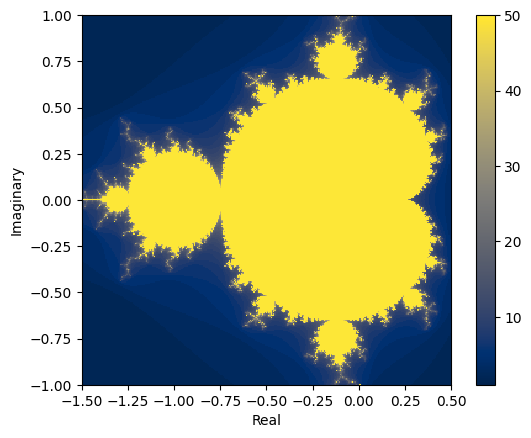

In [18]:
import matplotlib.pyplot as plt

plt.set_cmap("cividis")
plt.xlabel("Real")
plt.ylabel("Imaginary")
plt.imshow(
    result_numpy, interpolation="none", extent=[xmin, xmax, ymin, ymax], origin="lower"
)
plt.colorbar()

Even though we're doing unnecessary calculations (compared to our pure Python implementation), we are much faster.